# Plot decoding results

In [4]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import scipy.stats as st
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import sklearn as sk
import glob
import re
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor, compute_smoothed_response_rate

%matplotlib notebook

In [5]:
# ['MOs','ACA']+['all']

In [27]:
loadpath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results\by_session\pre_post_stim_activity_all_units'

svc_results={}
decoder_results=os.listdir(loadpath)

for ii,ff in enumerate(decoder_results):
    with open(os.path.join(loadpath,ff),'rb') as handle:
        svc_results[ii]=pickle.load(handle)
    print(ff)

626791_1decoder_results_200ms_incl_pre_post_all_units.pkl
626791_2decoder_results_200ms_incl_pre_post_all_units.pkl
626791_3decoder_results_200ms_incl_pre_post_all_units.pkl
636766_1decoder_results_200ms_incl_pre_post_all_units.pkl
636766_2decoder_results_200ms_incl_pre_post_all_units.pkl
636766_3decoder_results_200ms_incl_pre_post_all_units.pkl
636766_4decoder_results_200ms_incl_pre_post_all_units.pkl
644864_1decoder_results_200ms_incl_pre_post_all_units.pkl
644864_2decoder_results_200ms_incl_pre_post_all_units.pkl
644864_3decoder_results_200ms_incl_pre_post_all_units.pkl
644864_4decoder_results_200ms_incl_pre_post_all_units.pkl
644866_2decoder_results_200ms_incl_pre_post_all_units.pkl
644866_3decoder_results_200ms_incl_pre_post_all_units.pkl
644866_4decoder_results_200ms_incl_pre_post_all_units.pkl
644867_1decoder_results_200ms_incl_pre_post_all_units.pkl
644867_2decoder_results_200ms_incl_pre_post_all_units.pkl
644867_3decoder_results_200ms_incl_pre_post_all_units.pkl
644867_4decode

In [28]:
svc_results[0].keys()

dict_keys(['metadata', 'trial_numbers', 'unit_numbers', 'min_n_units', 'n_repeats', 'time_bins', 'balance_labels', 'block_ids'])

In [29]:
session_areas=[]
p='block_ids'
for sel_session in range(0,len(svc_results)):
    session_areas.append(list(svc_results[sel_session][p].keys()))
    
unique_areas=np.unique(np.hstack(session_areas))
unique_areas

array(['', 'ACB', 'AId', 'APN', 'AUDp', 'AUDpo', 'CA1', 'CA3', 'CL', 'CP',
       'DG', 'ILA', 'LD', 'LGd', 'LP', 'LSr', 'MB', 'MD', 'MGd', 'MGm',
       'MGv', 'MOp', 'MOs', 'MRN', 'N/A', 'ORBm', 'PO', 'POL', 'PoT',
       'ProS', 'RSPagl', 'RSPd', 'RSPv', 'SAG', 'SGN', 'SNr', 'SSp-bfd',
       'SSp-m', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SUB', 'TEa', 'VISa',
       'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpm', 'VISpor',
       'VISrl', 'VPL', 'VPM', 'all'], dtype='<U7')

In [30]:
# make into more plottable format

####change this to deal with multiple #s of trials and average over re-runs of the SVC

plot_results={}
plot_shuffle_results={}
predict_perf={}
predict_perf_shuffle={}
predict_perf_tridx={}
dec_func={}
dec_func_shuffle={}

timepoints=svc_results[0]['time_bins'][1:]

label_list=['vis1','vis2','sound1','sound2','True','False']
# label_list=['vis1','sound1','True','False']

# predict=['stim_ids','block_ids','trial_response']
predict=['block_ids']

# areas=['VISp','AUD','LG','MG','MOs','MRN','CP','MOp']
areas=unique_areas

for sel_session in range(0,len(svc_results)):
    plot_results[sel_session]={}
    plot_shuffle_results[sel_session]={}
    for aa in areas:
        plot_results[sel_session][aa]={}
        plot_shuffle_results[sel_session][aa]={}
        for p in predict:
            plot_results[sel_session][aa][p]={}
            plot_shuffle_results[sel_session][aa][p]={}
            for ll in label_list:
                plot_results[sel_session][aa][p][ll]=np.zeros((len(timepoints),svc_results[sel_session]['n_repeats']))
                plot_results[sel_session][aa][p][ll][:]=np.nan
                
                plot_shuffle_results[sel_session][aa][p][ll]=np.zeros((len(timepoints),svc_results[sel_session]['n_repeats']))
                plot_shuffle_results[sel_session][aa][p][ll][:]=np.nan
    
# predict_perf=np.zeros((len(trial_sel),n_repeats))
# for nn in range(0,n_repeats):
#     predict_perf[:,nn]=(svc_results[sel_session]['block_ids'][sel_session][p][aa][tt][nn]['cr']['pred_label']==
#                        svc_results[sel_session]['block_ids'][sel_session][p][aa][tt][nn]['cr']['true_label'])
for sel_session in range(0,len(svc_results)):
    predict_perf[sel_session]={}
    predict_perf_shuffle[sel_session]={}
    predict_perf_tridx[sel_session]={}
    dec_func[sel_session]={}
    dec_func_shuffle[sel_session]={}
    for aa in areas:
        if aa in svc_results[sel_session][p].keys():
            predict_perf[sel_session][aa]={}
            predict_perf_shuffle[sel_session][aa]={}
            predict_perf_tridx[sel_session][aa]={}
            dec_func[sel_session][aa]={}
            dec_func_shuffle[sel_session][aa]={}
            for p in predict:
                predict_perf[sel_session][aa][p]=np.zeros(
                    (len(svc_results[sel_session][p][aa][0][0]['pred_label']),svc_results[sel_session]['n_repeats']))
                predict_perf_shuffle[sel_session][aa][p]=np.zeros(
                    (len(svc_results[sel_session][p][aa][0][0]['pred_label']),svc_results[sel_session]['n_repeats']))
                predict_perf_tridx[sel_session][aa][p]=np.zeros(
                    (len(svc_results[sel_session][p][aa][0][0]['pred_label']),svc_results[sel_session]['n_repeats']))
                
                if 'decision_function' in svc_results[sel_session][p][aa][0][0].keys():
                    dec_func[sel_session][aa][p]=svc_results[sel_session][p][aa][0][0]['decision_function']
                    dec_func_shuffle[sel_session][aa][p]=svc_results[sel_session][p][aa][0][0]['shuffle']['decision_function']
                
                for nn in range(0,svc_results[sel_session]['n_repeats']):
                    if len(svc_results[sel_session][p][aa])>0:
                        if len(svc_results[sel_session][p][aa][0])>0:

                                predict_perf[sel_session][aa][p][:,nn]=(
                                    svc_results[sel_session][p][aa][0][nn]['pred_label']=='vis1')
#                                     svc_results[sel_session][p][aa][0][nn]['true_label'])

                                predict_perf_shuffle[sel_session][aa][p][:,nn]=(
                                    svc_results[sel_session][p][aa][0][nn]['shuffle']['pred_label']=='vis1')
#                                     svc_results[sel_session][p][aa][0][nn]['shuffle']['true_label'])

                                predict_perf_tridx[sel_session][aa][p][:,nn]=(
                                    svc_results[sel_session][p][aa][0][nn]['trial_sel_idx'])
    
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

decoder_acc_session_mean = {}
decoder_acc_session_shuffle_mean = {}
for aa in areas:
    decoder_acc_session_mean[aa]={}
    decoder_acc_session_shuffle_mean[aa]={}
    for p in predict:
        decoder_acc_session_mean[aa][p]={}
        decoder_acc_session_shuffle_mean[aa][p]={}
        for ll in label_list:
            
            decoder_acc_session_mean[aa][p][ll]=np.zeros((len(timepoints),
                                                           len(svc_results)))
            decoder_acc_session_mean[aa][p][ll][:]=np.nan
            
            decoder_acc_session_shuffle_mean[aa][p][ll]=np.zeros((len(timepoints),
                                                           len(svc_results)))
            decoder_acc_session_shuffle_mean[aa][p][ll][:]=np.nan
        

for sel_session in range(0,len(svc_results)):
    for p in predict:
        for aa in areas: 
            if aa in svc_results[sel_session][p].keys():
                for tt,tp in enumerate(timepoints):
                    for nn in range(0,svc_results[sel_session]['n_repeats']):
                        for ll in label_list:
                            if len(svc_results[sel_session][p][aa])>0:
                                if len(svc_results[sel_session][p][aa][tt])>0:
                                    if ll in svc_results[sel_session][p][aa][tt][nn]['cr'].keys():
                                        temp_perf=np.nanmean(svc_results[sel_session][p]
                                                          [aa][tt][nn]['cr'][ll]
                                                          [['precision','recall']].values)
                                        plot_results[sel_session][aa][p][ll][tt,nn]=temp_perf
                                        
                                        temp_shuff_perf=np.nanmean(svc_results[sel_session][p]
                                                          [aa][tt][nn]['shuffle']['cr'][ll]
                                                          [['precision','recall']].values)
                                        plot_shuffle_results[sel_session][aa][p][ll][tt,nn]=temp_shuff_perf

                    for ll in label_list:
                        if len(svc_results[sel_session][p][aa])>0:                    
                            decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
                            decoder_acc_session_mean[aa][p][ll][tt,sel_session] = decoder_acc_mean
    
                            decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
                            decoder_acc_session_shuffle_mean[aa][p][ll][tt,sel_session] = decoder_acc_shuffle_mean
# plot_results[area][label/stimulus][timepoint_idx][ntrials_idx,nunits_idx,n_repeats]

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mc

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mc

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:132: RuntimeWarning: Mean of empty slice
  decoder_acc_shuffle_mean = np.nanmean(plot_shuffle_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26012\4158984178.py:129: RuntimeWarning: Mean of empty slice
  decoder_acc_mean = np.nanmean(plot_results[sel_session][aa][p][ll][tt])
C:\Users\ethan.mcbride\AppData\Lo

In [10]:
# np.mean(predict_perf[sel_session][aa][p],axis=1)
# svc_results[sel_session][p][aa][0][nn]['trial_sel_idx']
svc_results[0][p][aa][0][nn].keys()

dict_keys(['cr', 'pred_label', 'true_label', 'trial_sel_idx', 'trials_used', 'decision_function', 'coefs', 'classes', 'intercept', 'params', 'shuffle', 'unit_sel_idx'])

In [ ]:
sel_session

<IPython.core.display.Javascript object>


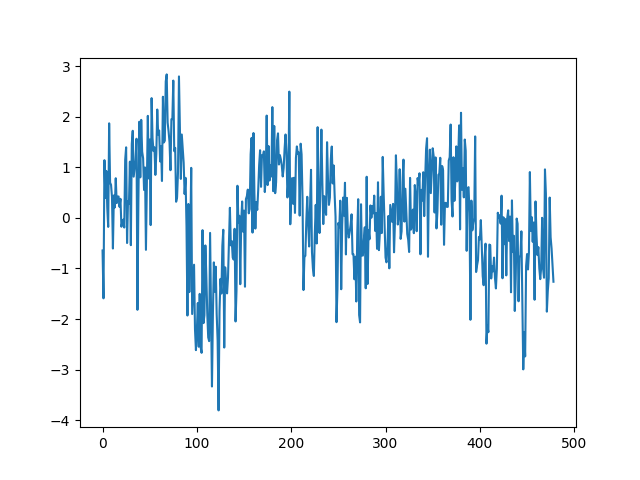

In [31]:
fig,ax=plt.subplots()
ax.plot(dec_func[0]['MOs']['block_ids'])

In [ ]:
fig,ax=plt.subplots()
ax.hist(dec_func[6]['MOs']['block_ids'],bins=40)

In [ ]:
np.std(dec_func[4]['MOs']['block_ids'])

In [ ]:
X=dec_func[3]['MOs']['block_ids']

fract=0.5

# np.mean((X<-np.std(X))|(X>np.std(X)))
np.mean((X>(-np.std(X)*fract))&(X<(np.std(X)*fract)))

<IPython.core.display.Javascript object>


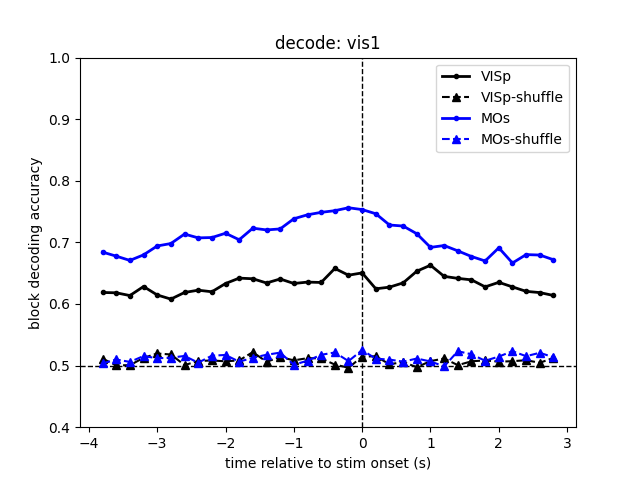

In [32]:
predict_var='block_ids'
sel_stim='vis1'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
ax.axhline(0.5,color='k',linestyle='--',linewidth=1)

# ax.plot(time_bins[1:],decoder_acc_session_mean['VISp'][predict_var][sel_stim],'k',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['AUDp'][predict_var][sel_stim],'m',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['MOs'][predict_var][sel_stim],'b',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['MRN'][predict_var][sel_stim],'r',linewidth=0.75,alpha=0.5)
# ax.plot(time_bins[1:],decoder_acc_session_mean['CP'][predict_var][sel_stim],'g',linewidth=0.75,alpha=0.5)


visp_line=ax.plot(timepoints,np.nanmean(decoder_acc_session_mean['VISp'][predict_var][sel_stim],axis=1)
        ,'k.-',linewidth=2)

visp_line_balance_running=ax.plot(timepoints,
                                  np.nanmean(decoder_acc_session_shuffle_mean['VISp'][predict_var][sel_stim],axis=1)
                                  ,'k^--',linewidth=1.5)

# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['AUDp'][predict_var][sel_stim],axis=1)
#         ,'m.-',linewidth=2)
mos_line=ax.plot(timepoints,np.nanmean(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)
        ,'b.-',linewidth=2)

mos_line_balance_running=ax.plot(timepoints,
                                  np.nanmean(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)
                                  ,'b^--',linewidth=1.5)

# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['MRN'][predict_var][sel_stim],axis=1)
#         ,'r.-',linewidth=2)
# ax.plot(time_bins[1:],np.nanmean(decoder_acc_session_mean['CP'][predict_var][sel_stim],axis=1)
#         ,'g.-',linewidth=2)


ax.set_ylim([0.4,1.0])
ax.set_xlabel('time relative to stim onset (s)')
ax.set_ylabel('block decoding accuracy')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
          ['VISp','VISp-shuffle','MOs','MOs-shuffle'])

<IPython.core.display.Javascript object>


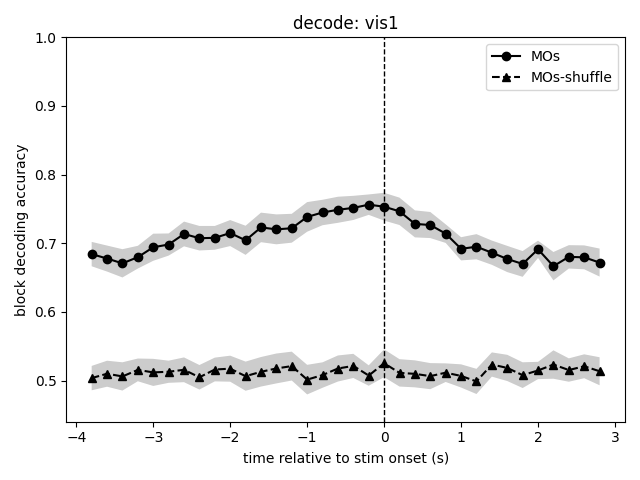

In [33]:
#shaded error bars - MOs only

predict_var='block_ids'
sel_stim='vis1'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
# ax.axhline(0.25,color='k',linestyle='--',linewidth=1)


y1=np.nanmean(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)
err1=(np.nanstd(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_mean['MOs'][predict_var][sel_stim][0,:]))))
l1=ax.plot(timepoints, y1,'k',linestyle='-',marker='o')
plt.fill_between(timepoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='k')


y2=np.nanmean(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)
err2=(np.nanstd(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim][0,:]))))
l2=ax.plot(timepoints, y2,'k',linestyle='--',marker='^')
plt.fill_between(timepoints, y2-err1, y2+err1,
    alpha=0.2, edgecolor=None, facecolor='k')


if predict_var=='block_ids':
    ax.set_ylim([0.44,1.0])
    ax.set_ylabel('block decoding accuracy')
    
elif predict_var=='stim_ids':
    ax.set_ylim([0.15,1.0])
    ax.set_ylabel('stimulus decoding accuracy')
    
ax.set_xlabel('time relative to stim onset (s)')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
ax.legend([l1[0],l2[0]],['MOs','MOs-shuffle'])
fig.tight_layout()

<IPython.core.display.Javascript object>


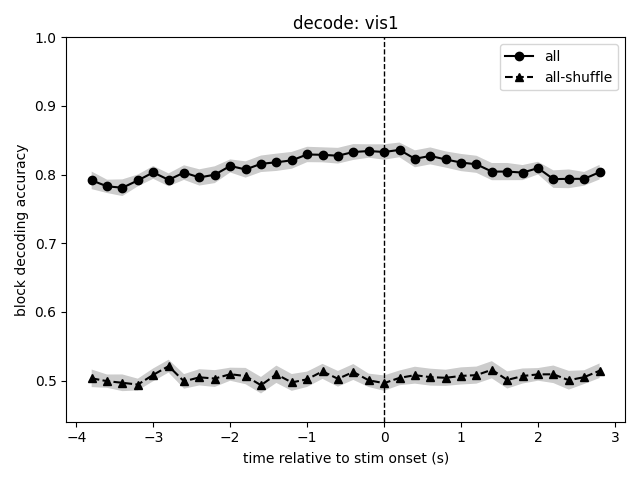

In [36]:
#shaded error bars - MOs only

predict_var='block_ids'
sel_stim='vis1'
sel_area='all'

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
# ax.axhline(0.25,color='k',linestyle='--',linewidth=1)


y1=np.nanmean(decoder_acc_session_mean[sel_area][predict_var][sel_stim],axis=1)
err1=(np.nanstd(decoder_acc_session_mean[sel_area][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_mean[sel_area][predict_var][sel_stim][0,:]))))
l1=ax.plot(timepoints, y1,'k',linestyle='-',marker='o')
plt.fill_between(timepoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='k')


y2=np.nanmean(decoder_acc_session_shuffle_mean[sel_area][predict_var][sel_stim],axis=1)
err2=(np.nanstd(decoder_acc_session_shuffle_mean[sel_area][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_shuffle_mean[sel_area][predict_var][sel_stim][0,:]))))
l2=ax.plot(timepoints, y2,'k',linestyle='--',marker='^')
plt.fill_between(timepoints, y2-err1, y2+err1,
    alpha=0.2, edgecolor=None, facecolor='k')


if predict_var=='block_ids':
    ax.set_ylim([0.44,1.0])
    ax.set_ylabel('block decoding accuracy')
    
elif predict_var=='stim_ids':
    ax.set_ylim([0.15,1.0])
    ax.set_ylabel('stimulus decoding accuracy')
    
ax.set_xlabel('time relative to stim onset (s)')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
ax.legend([l1[0],l2[0]],[sel_area,sel_area+'-shuffle'])
fig.tight_layout()

<IPython.core.display.Javascript object>


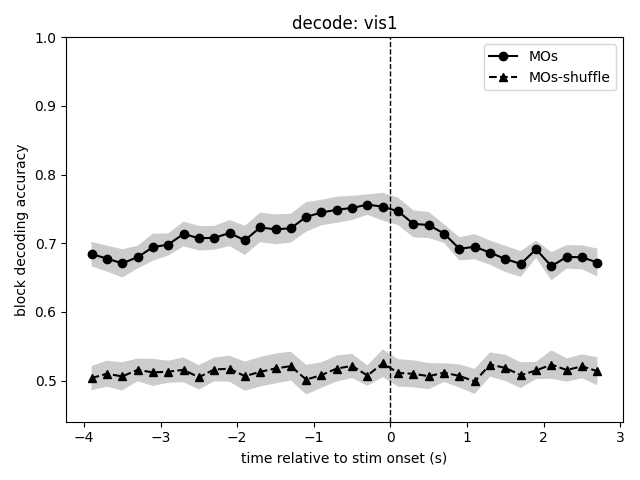

In [37]:
#shift bins plot position - try with and without connecting lines

predict_var='block_ids'
sel_stim='vis1'

timepoint_midpoints=(svc_results[0]['time_bins'][1:]+svc_results[0]['time_bins'][:-1])/2

fig,ax=plt.subplots(1,1)

ax.axvline(0,color='k',linestyle='--',linewidth=1)
# ax.axhline(0.25,color='k',linestyle='--',linewidth=1)


y1=np.nanmean(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)
err1=(np.nanstd(decoder_acc_session_mean['MOs'][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_mean['MOs'][predict_var][sel_stim][0,:]))))
l1=ax.plot(timepoint_midpoints, y1,'k',linestyle='-',marker='o')
plt.fill_between(timepoint_midpoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='k')
# l1=ax.errorbar(timepoint_midpoints, y1, err1, color='k',linestyle='',marker='o')

y2=np.nanmean(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)
err2=(np.nanstd(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim],axis=1)/
      np.sqrt(np.sum(~np.isnan(decoder_acc_session_shuffle_mean['MOs'][predict_var][sel_stim][0,:]))))
l2=ax.plot(timepoint_midpoints, y2,'k',linestyle='--',marker='^')
plt.fill_between(timepoint_midpoints, y2-err1, y2+err1,
    alpha=0.2, edgecolor=None, facecolor='k')
# l2=ax.errorbar(timepoint_midpoints, y2, err2, color='k',linestyle='',marker='^')

if predict_var=='block_ids':
    ax.set_ylim([0.44,1.0])
    ax.set_ylabel('block decoding accuracy')
    
elif predict_var=='stim_ids':
    ax.set_ylim([0.15,1.0])
    ax.set_ylabel('stimulus decoding accuracy')

ax.set_xlabel('time relative to stim onset (s)')
ax.set_title('decode: '+sel_stim)
# ax.legend([visp_line[0],mos_line[0]],['VISp','MOs'])
# ax.legend([visp_line[0],visp_line_balance_running[0],mos_line[0],mos_line_balance_running[0]],
#           ['VISp','VISp-balanced running','MOs','MOs-balanced running'])
ax.legend([l1[0],l2[0]],['MOs','MOs-shuffle'])
fig.tight_layout()

In [12]:
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
    
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed", 
    r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed",
#     r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644866_20230207\processed", 
    #some error with this one's processing ^
    r"Y:\DRpilot_644866_20230208\processed",
    r"Y:\DRpilot_644866_20230209\processed",
    r"Y:\DRpilot_644866_20230210\processed",
    r"Y:\DRpilot_644867_20230220\processed",
    r"Y:\DRpilot_644867_20230221\processed",
    r"Y:\DRpilot_644867_20230222\processed",
    r"Y:\DRpilot_644867_20230223\processed",
    r"Y:\DRpilot_649943_20230213\processed", 
    r"Y:\DRpilot_649943_20230214\processed",
    r"Y:\DRpilot_649943_20230215\processed",
    r"Y:\DRpilot_649943_20230216\processed",
]

In [13]:
#load all sessions

sessions={}

for mi,mm in enumerate(main_path):
    sessions[mi]=Session(path=mm)
    sessions[mi].assign_unit_areas()
#     sessions[mi]=compute_smoothed_response_rate(sessions[mi])
    


probeA areas found
probeB areas found
probeC areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeA areas found
probeB areas found
probeC areas found
probeD areas not found
probeE areas found
probeF areas found
probeA areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found
probeA areas found
probeB areas found
probeC areas found
probeD areas not found
probeE areas found
probeF areas found
probeA areas found
probeB areas found
prob

In [14]:
sessions[0].trials.columns

Index(['trialStartFrame', 'trialStimID', 'trialstimRewarded', 'trial_response',
       'trial_rewarded', 'trial_sound_dur', 'trial_vis_stim_dur',
       'vis_go_trials', 'vis_nogo_trials', 'vis_hit_trials',
       'vis_false_alarm_trials', 'vis_miss_trials',
       'vis_correct_reject_trials', 'vis_autoreward_trials', 'aud_go_trials',
       'aud_nogo_trials', 'aud_hit_trials', 'aud_false_alarm_trials',
       'aud_miss_trials', 'aud_correct_reject_trials', 'aud_autoreward_trials',
       'catch_trials', 'catch_resp_trials', 'trialStimStartFrame',
       'stimStartTime', 'stimLatency', 'trial_stim_dur', 'avg_run_speed'],
      dtype='object')

In [15]:
# load trials from all sessions and get probability of licking for visual vs. auditory target

trial_info={}

#save trialStimID, trial_response

#make vis_target_response and aud_target_response vectors
#regardless of block!

for ss in sessions:
    trial_info[ss]={}
    
    block_transitions=np.where(
        sessions[ss].trials['trialstimRewarded'][:-1].values!=
        sessions[ss].trials['trialstimRewarded'][1:].values)[0]+1
    block_transitions=np.hstack([0,block_transitions,len(sessions[ss].trials)-1])

    block_number=np.zeros(len(sessions[ss].trials))
    block_number[:]=np.nan

    for bb in range(1,len(block_transitions)):
        block_number[block_transitions[bb-1]:block_transitions[bb]]=bb

    sessions[ss].trials['block_number']=block_number
    
    
    if 'trialOptoVoltage' in sessions[ss].trials.columns:
        trial_sel = sessions[ss].trials.query('trialOptoVoltage.isnull()').index
    else:
        trial_sel = sessions[ss].trials.index
        
    trial_info[ss]['trialStimID']=sessions[ss].trials['trialStimID'].loc[trial_sel].values
    trial_info[ss]['trialstimRewarded']=sessions[ss].trials['trialstimRewarded'].loc[trial_sel].values
    trial_info[ss]['trial_response']=sessions[ss].trials['trial_response'].loc[trial_sel].values
    trial_info[ss]['trial_rewarded']=sessions[ss].trials['trial_rewarded'].loc[trial_sel].values
    
    trial_info[ss]['autoreward']=((sessions[ss].trials['vis_autoreward_trials'].loc[trial_sel] ==True)| 
                                  (sessions[ss].trials['aud_autoreward_trials'].loc[trial_sel] == True)).values
    
    trial_info[ss]['vis_target']=(trial_info[ss]['trialStimID']=='vis1')
    trial_info[ss]['aud_target']=(trial_info[ss]['trialStimID']=='sound1')
    
    trial_info[ss]['vis_target_response']=((trial_info[ss]['trialStimID']=='vis1')&
                                           (trial_info[ss]['trial_response']==True))
    trial_info[ss]['aud_target_response']=((trial_info[ss]['trialStimID']=='sound1')&
                                           (trial_info[ss]['trial_response']==True))
    
    trial_info[ss]['block_number']=sessions[ss].trials['block_number'].loc[trial_sel].values
    


In [ ]:
# xbins=np.arange(-1,1.1,0.5)
# trial_info[ss]['autoreward']

In [18]:
# find probability of response depending on decoder accuracy

aa='all'
p='block_ids'

# xbins=np.arange(-1,1.01,0.66667)
xbins = np.asarray([-1.1,-1/3,1/3,1.1])
xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

# sel_session=0

for sel_session in sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
        
    incl_trials = ~trial_info[sel_session]['autoreward']
    
    # vis_resp_prob=np.zeros(len(xbin_midpoints))
    # aud_resp_prob=np.zeros(len(xbin_midpoints))

    decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
    block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
#     stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]
    stim_label=trial_info[sel_session]['trialStimID'][incl_trials]

#     #make sound blocks a negative prediction
#     for xx in range(0,len(decoder_pred)):
#         if 'sound' in block_label[xx]:
#             decoder_pred[xx]=-decoder_pred[xx]
    decoder_pred = (decoder_pred*2)-1

    vis_target_response=trial_info[sel_session]['vis_target_response'][incl_trials]
    aud_target_response=trial_info[sel_session]['aud_target_response'][incl_trials]

    for bb in range(0,len(xbins[:-1])):

        vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob[bb,sel_session]):
            vis_resp_prob[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob[bb,sel_session]):
            aud_resp_prob[bb,sel_session]=0

        
fig,ax1=plt.subplots()
#vis performance plot
color = 'blue'
ax1.set_xlabel('auditory <- decoder context prediction -> visual')
ax1.set_ylabel('prob. aud target lick', color=color)
ax1.plot(xbin_midpoints,aud_resp_prob,color=color,linewidth=0.75,alpha=0.5)
ax1.plot(xbin_midpoints,np.nanmean(aud_resp_prob,axis=1),color=color,linewidth=2,marker='o')
ax1.tick_params(axis ='y', labelcolor = color)
# ax1.set_ylim([0.2,1.1])
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'green'
ax2.set_ylabel('prob. vis target lick', color=color)
ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
ax2.tick_params(axis ='y', labelcolor = color)
# ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax1.set_title('area '+aa)

TypeError: unhashable type: 'slice'

In [17]:
# block_label[incl_trials]
sel_session

5

In [ ]:
# find probability of response depending on decoder accuracy
# PLOT WITH STDERROR!

aa='MOs'
p='block_ids'

# xbins=np.arange(-1,1.01,0.66667)
# xbins = np.asarray([-1.1,-1/3,1/3,1.1])
xbins = np.asarray([-0.01,1/3,2/3,1.01])
xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

vis_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob_shuffle[:]=np.nan
aud_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob_shuffle[:]=np.nan

# sel_session=0

for sel_session in sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
    
    incl_trials = ~trial_info[sel_session]['autoreward']
    
    # vis_resp_prob=np.zeros(len(xbin_midpoints))
    # aud_resp_prob=np.zeros(len(xbin_midpoints))

    decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
    decoder_pred_shuffle = np.random.choice(decoder_pred,len(decoder_pred),replace=False)
    block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
#     stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]
    stim_label=trial_info[sel_session]['trialStimID'][incl_trials]
#     #make sound blocks a negative prediction
#     for xx in range(0,len(decoder_pred)):
#         if 'sound' in block_label[xx]:
#             decoder_pred[xx]=-decoder_pred[xx]
#     decoder_pred = (decoder_pred*2)-1

    vis_target_response=trial_info[sel_session]['vis_target_response'][incl_trials]
    aud_target_response=trial_info[sel_session]['aud_target_response'][incl_trials]

    for bb in range(0,len(xbins[:-1])):

        vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob[bb,sel_session]):
            vis_resp_prob[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob[bb,sel_session]):
            aud_resp_prob[bb,sel_session]=0
            
        #shuffle
        vis_trial_idx=(stim_label=='vis1')&(decoder_pred_shuffle>=xbins[bb])&(decoder_pred_shuffle<xbins[bb+1])
        vis_resp_prob_shuffle[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob_shuffle[bb,sel_session]):
            vis_resp_prob_shuffle[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred_shuffle>=xbins[bb])&(decoder_pred_shuffle<xbins[bb+1])
        aud_resp_prob_shuffle[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob_shuffle[bb,sel_session]):
            aud_resp_prob_shuffle[bb,sel_session]=0

        
fig,ax=plt.subplots()

#vis performance plot

ax.set_xlabel('decoder prob. predicting visual context')
ax.set_ylabel('prob. lick')

y1=np.nanmean(aud_resp_prob,axis=1)
err1=np.nanstd(aud_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob[0,:])))
l1=ax.plot(xbin_midpoints, y1,'b',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='b')

y2=np.nanmean(vis_resp_prob,axis=1)
err2=np.nanstd(vis_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob[0,:])))
l2=ax.plot(xbin_midpoints, y2,'g',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y2-err2, y2+err2,
    alpha=0.2, edgecolor=None, facecolor='g')


# y0=np.nanmean(aud_resp_prob_shuffle,axis=1)
# err0=np.nanstd(aud_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob_shuffle[0,:])))
# l0=ax.plot(xbin_midpoints, y0,'b',linestyle='--',alpha=0.5)
# plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
#     alpha=0.1, edgecolor=None, facecolor='b')

# y0=np.nanmean(vis_resp_prob_shuffle,axis=1)
# err0=np.nanstd(vis_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob_shuffle[0,:])))
# l0=ax.plot(xbin_midpoints, y0,'g',linestyle='--',alpha=0.5)
# plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
#     alpha=0.1, edgecolor=None, facecolor='g')

ax.set_ylim([0.2,1.1])
 
ax.legend(['aud. targets','vis. targets'])
    
# Adding Twin Axes to plot using dataset_2
# ax2 = ax1.twinx()
 
# color = 'green'
# ax2.set_ylabel('prob. vis target lick', color=color)
# ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
# ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
# ax2.tick_params(axis ='y', labelcolor = color)
# ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax.set_title('area '+aa)

In [ ]:
len(svc_results)

<IPython.core.display.Javascript object>


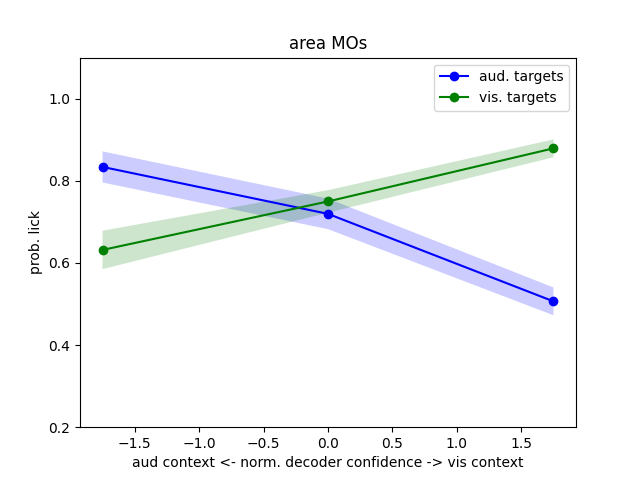

Text(0.5, 1.0, 'area MOs')

In [38]:
# find probability of response depending on decoder accuracy
# USE DECISION FUNCTION!

aa='MOs'
p='block_ids'

# xbins=np.arange(-1,1.01,0.66667)
# xbins = np.asarray([-1.01,-1/3,1/3,1.01])
xbins = np.asarray([-3,-1/2,1/2,3])
# xbins = np.asarray([-3,-1,-1/2,0,1/2,1,3])
# xbins = np.asarray([-0.01,1/3,2/3,1.01])



xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

vis_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob_shuffle[:]=np.nan
aud_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob_shuffle[:]=np.nan

# sel_session=0

for sel_session in range(0,len(svc_results)): #sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
    
    incl_trials = ~trial_info[sel_session]['autoreward']
    
    # vis_resp_prob=np.zeros(len(xbin_midpoints))
    # aud_resp_prob=np.zeros(len(xbin_midpoints))

#     decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
    decoder_pred=(dec_func[sel_session][aa][p][incl_trials])/np.nanstd(dec_func[sel_session][aa][p][incl_trials])
    decoder_pred_shuffle = np.random.choice(decoder_pred,len(decoder_pred),replace=False)
    block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
#     stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]
    stim_label=trial_info[sel_session]['trialStimID'][incl_trials]
#     #make sound blocks a negative prediction
#     for xx in range(0,len(decoder_pred)):
#         if 'sound' in block_label[xx]:
#             decoder_pred[xx]=-decoder_pred[xx]
#     decoder_pred = (decoder_pred*2)-1

    vis_target_response=trial_info[sel_session]['vis_target_response'][incl_trials]
    aud_target_response=trial_info[sel_session]['aud_target_response'][incl_trials]

    for bb in range(0,len(xbins[:-1])):
        
        min_edge=xbins[bb]
        max_edge=xbins[bb+1]
        if bb==0:
            min_edge=-1000
        elif bb==len(xbins[:-1])-1:
            max_edge=1000
            
        vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
        vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob[bb,sel_session]):
            vis_resp_prob[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
        aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob[bb,sel_session]):
            aud_resp_prob[bb,sel_session]=0
            
        #shuffle
        vis_trial_idx=(stim_label=='vis1')&(decoder_pred_shuffle>=min_edge)&(decoder_pred_shuffle<max_edge)
        vis_resp_prob_shuffle[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob_shuffle[bb,sel_session]):
            vis_resp_prob_shuffle[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred_shuffle>=min_edge)&(decoder_pred_shuffle<max_edge)
        aud_resp_prob_shuffle[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob_shuffle[bb,sel_session]):
            aud_resp_prob_shuffle[bb,sel_session]=0

        
fig,ax=plt.subplots()

#vis performance plot

ax.set_xlabel('aud context <- norm. decoder confidence -> vis context')
ax.set_ylabel('prob. lick')

y1=np.nanmean(aud_resp_prob,axis=1)
err1=np.nanstd(aud_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob[0,:])))
l1=ax.plot(xbin_midpoints, y1,'b',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='b')

y2=np.nanmean(vis_resp_prob,axis=1)
err2=np.nanstd(vis_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob[0,:])))
l2=ax.plot(xbin_midpoints, y2,'g',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y2-err2, y2+err2,
    alpha=0.2, edgecolor=None, facecolor='g')


# y0=np.nanmean(aud_resp_prob_shuffle,axis=1)
# err0=np.nanstd(aud_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob_shuffle[0,:])))
# l0=ax.plot(xbin_midpoints, y0,'b',linestyle='--',alpha=0.5)
# plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
#     alpha=0.1, edgecolor=None, facecolor='b')

# y0=np.nanmean(vis_resp_prob_shuffle,axis=1)
# err0=np.nanstd(vis_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob_shuffle[0,:])))
# l0=ax.plot(xbin_midpoints, y0,'g',linestyle='--',alpha=0.5)
# plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
#     alpha=0.1, edgecolor=None, facecolor='g')

ax.set_ylim([0.2,1.1])
 
ax.legend(['aud. targets','vis. targets'])
    
# Adding Twin Axes to plot using dataset_2
# ax2 = ax1.twinx()
 
# color = 'green'
# ax2.set_ylabel('prob. vis target lick', color=color)
# ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
# ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
# ax2.tick_params(axis ='y', labelcolor = color)
# ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax.set_title('area '+aa)

In [ ]:
# trial_info[0]['vis_target_response']

<IPython.core.display.Javascript object>


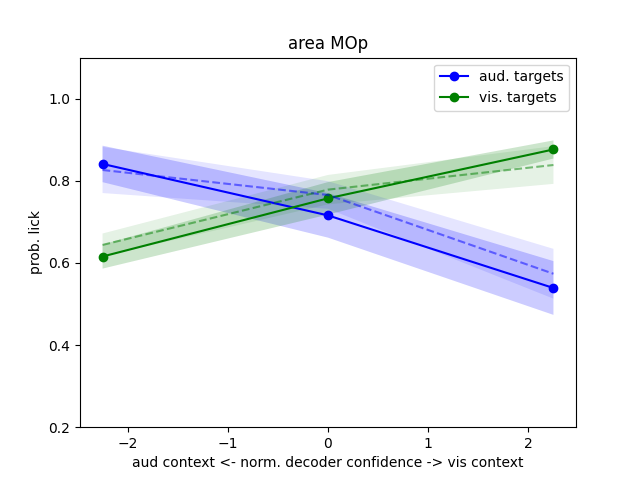

Text(0.5, 1.0, 'area MOp')

In [39]:
## same but with shuffle correction
## shuffle within blocks


# find probability of response depending on decoder accuracy
# USE DECISION FUNCTION!

aa='MOp'
p='block_ids'

# xbins=np.arange(-1,1.01,0.66667)
# xbins = np.asarray([-1.01,-1/3,1/3,1.01])
xbins = np.asarray([-4,-1/2,1/2,4])
# xbins = np.asarray([-3,-1,-1/2,0,1/2,1,3])
# xbins = np.asarray([-0.01,1/3,2/3,1.01])



xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

vis_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob_shuffle[:]=np.nan
aud_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob_shuffle[:]=np.nan

# sel_session=0

for sel_session in range(0,len(svc_results)): #sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
    
    incl_trials = ~trial_info[sel_session]['autoreward']
    
    # vis_resp_prob=np.zeros(len(xbin_midpoints))
    # aud_resp_prob=np.zeros(len(xbin_midpoints))

#     decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
    decoder_pred=(dec_func[sel_session][aa][p][incl_trials])/np.nanstd(dec_func[sel_session][aa][p][incl_trials])
    decoder_pred_shuffle = np.random.choice(decoder_pred,len(decoder_pred),replace=False)
    
    decoder_pred_shuffle_by_block=np.zeros(len(decoder_pred))
    decoder_pred_shuffle_by_block[:]=np.nan
    block_num_incl=trial_info[sel_session]['block_number'][incl_trials]
    for bl in np.unique(block_num_incl):
        blockind=block_num_incl==bl
        decoder_pred_shuffle_by_block[blockind]=np.random.choice(decoder_pred[blockind],np.sum(blockind),replace=False)
    
    block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
#     stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]
    stim_label=trial_info[sel_session]['trialStimID'][incl_trials]
#     #make sound blocks a negative prediction
#     for xx in range(0,len(decoder_pred)):
#         if 'sound' in block_label[xx]:
#             decoder_pred[xx]=-decoder_pred[xx]
#     decoder_pred = (decoder_pred*2)-1

    vis_target_response=trial_info[sel_session]['vis_target_response'][incl_trials]
    aud_target_response=trial_info[sel_session]['aud_target_response'][incl_trials]

    for bb in range(0,len(xbins[:-1])):
        
        min_edge=xbins[bb]
        max_edge=xbins[bb+1]
        if bb==0:
            min_edge=-1000
        elif bb==len(xbins[:-1])-1:
            max_edge=1000
            
        vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
        vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
#         if np.isnan(vis_resp_prob[bb,sel_session]):
#             vis_resp_prob[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
        aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
#         if np.isnan(aud_resp_prob[bb,sel_session]):
#             aud_resp_prob[bb,sel_session]=0
            
        #shuffle
        vis_trial_idx=(stim_label=='vis1')&(decoder_pred_shuffle_by_block>=min_edge)&(decoder_pred_shuffle_by_block<max_edge)
        vis_resp_prob_shuffle[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
#         if np.isnan(vis_resp_prob_shuffle[bb,sel_session]):
#             vis_resp_prob_shuffle[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred_shuffle_by_block>=min_edge)&(decoder_pred_shuffle_by_block<max_edge)
        aud_resp_prob_shuffle[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
#         if np.isnan(aud_resp_prob_shuffle[bb,sel_session]):
#             aud_resp_prob_shuffle[bb,sel_session]=0

        
fig,ax=plt.subplots()

#vis performance plot

ax.set_xlabel('aud context <- norm. decoder confidence -> vis context')
ax.set_ylabel('prob. lick')

y1=np.nanmean(aud_resp_prob,axis=1)
err1=np.nanstd(aud_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob[0,:])))
l1=ax.plot(xbin_midpoints, y1,'b',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='b')

y2=np.nanmean(vis_resp_prob,axis=1)
err2=np.nanstd(vis_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob[0,:])))
l2=ax.plot(xbin_midpoints, y2,'g',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y2-err2, y2+err2,
    alpha=0.2, edgecolor=None, facecolor='g')


y0=np.nanmean(aud_resp_prob_shuffle,axis=1)
err0=np.nanstd(aud_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob_shuffle[0,:])))
l0=ax.plot(xbin_midpoints, y0,'b',linestyle='--',alpha=0.5)
plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
    alpha=0.1, edgecolor=None, facecolor='b')

y0=np.nanmean(vis_resp_prob_shuffle,axis=1)
err0=np.nanstd(vis_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob_shuffle[0,:])))
l0=ax.plot(xbin_midpoints, y0,'g',linestyle='--',alpha=0.5)
plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
    alpha=0.1, edgecolor=None, facecolor='g')

ax.set_ylim([0.2,1.1])
 
ax.legend(['aud. targets','vis. targets'])
    
# Adding Twin Axes to plot using dataset_2
# ax2 = ax1.twinx()
 
# color = 'green'
# ax2.set_ylabel('prob. vis target lick', color=color)
# ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
# ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
# ax2.tick_params(axis ='y', labelcolor = color)
# ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax.set_title('area '+aa)




In [ ]:
# trial_info[20]['block_number'][incl_trials]
# trial_info[sel_session]['autoreward']
# decoder_pred_shuffle_by_block

In [ ]:
sel_session

In [ ]:
# decoder_pred_shuffle_by_block

<IPython.core.display.Javascript object>


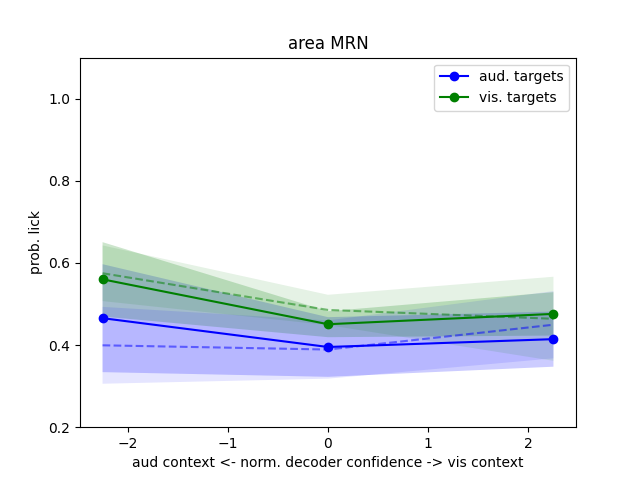

Text(0.5, 1.0, 'area MRN')

In [40]:
### separately correlate prob. lick and decoder confidence


aa='MRN'
p='block_ids'
block_type=['vis1','sound1']

# xbins=np.arange(-1,1.01,0.66667)
# xbins = np.asarray([-1.01,-1/3,1/3,1.01])
xbins = np.asarray([-4,-1/2,1/2,4])
# xbins = np.asarray([-3,-1,-1/2,0,1/2,1,3])
# xbins = np.asarray([-0.01,1/3,2/3,1.01])
# xbins = np.asarray([-2,0,2])
# xbins = np.asarray([0,1/2,1,4])

xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

vis_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob_shuffle[:]=np.nan
aud_resp_prob_shuffle=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob_shuffle[:]=np.nan

# sel_session=0

for sel_session in range(0,len(svc_results)): #sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
    
    for block in block_type:
        incl_trials = (~trial_info[sel_session]['autoreward'])&(trial_info[sel_session]['trialstimRewarded']==block)

        # vis_resp_prob=np.zeros(len(xbin_midpoints))
        # aud_resp_prob=np.zeros(len(xbin_midpoints))

    #     decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
        
        decoder_pred=((dec_func[sel_session][aa][p][incl_trials]-
                       np.nanmean(dec_func[sel_session][aa][p][incl_trials]))
                      /np.nanstd(dec_func[sel_session][aa][p][incl_trials]))

#         decoder_pred=((dec_func[sel_session][aa][p][incl_trials])
#                       /np.nanstd(dec_func[sel_session][aa][p][incl_trials]))
#         if block=='sound1':
#         decoder_pred=np.abs(decoder_pred)
        decoder_pred_shuffle = np.random.choice(decoder_pred,len(decoder_pred),replace=False)

#         decoder_pred_shuffle_by_block=np.zeros(len(decoder_pred))
#         decoder_pred_shuffle_by_block[:]=np.nan
#         block_num_incl=trial_info[sel_session]['block_number'][incl_trials]
#         for bb in np.unique(block_num_incl):
#             blockind=block_num_incl==bb
#             decoder_pred_shuffle_by_block[blockind]=np.random.choice(decoder_pred[blockind],np.sum(blockind),replace=False)

        block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
#         stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]
        stim_label=trial_info[sel_session]['trialStimID'][incl_trials]
    #     #make sound blocks a negative prediction
    #     for xx in range(0,len(decoder_pred)):
    #         if 'sound' in block_label[xx]:
    #             decoder_pred[xx]=-decoder_pred[xx]
    #     decoder_pred = (decoder_pred*2)-1

        vis_target_response=trial_info[sel_session]['vis_target_response'][incl_trials]
        aud_target_response=trial_info[sel_session]['aud_target_response'][incl_trials]

        for bb in range(0,len(xbins[:-1])):

            min_edge=xbins[bb]
            max_edge=xbins[bb+1]
            if bb==0:
                min_edge=-1000
            elif bb==len(xbins[:-1])-1:
                max_edge=1000
            
            if block=='sound1':
                vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
                vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        #         if np.isnan(vis_resp_prob[bb,sel_session]):
        #             vis_resp_prob[bb,sel_session]=0
                #shuffle
                vis_trial_idx=(stim_label=='vis1')&(decoder_pred_shuffle>=min_edge)&(decoder_pred_shuffle<max_edge)
                vis_resp_prob_shuffle[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        #         if np.isnan(vis_resp_prob_shuffle[bb,sel_session]):
        #             vis_resp_prob_shuffle[bb,sel_session]=0
            
            elif block=='vis1':
                aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=min_edge)&(decoder_pred<max_edge)
                aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        #         if np.isnan(aud_resp_prob[bb,sel_session]):
        #             aud_resp_prob[bb,sel_session]=0
                #shuffle
                aud_trial_idx=(stim_label=='sound1')&(decoder_pred_shuffle>=min_edge)&(decoder_pred_shuffle<max_edge)
                aud_resp_prob_shuffle[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        #         if np.isnan(aud_resp_prob_shuffle[bb,sel_session]):
        #             aud_resp_prob_shuffle[bb,sel_session]=0

        
fig,ax=plt.subplots()

#vis performance plot

ax.set_xlabel('aud context <- norm. decoder confidence -> vis context')
ax.set_ylabel('prob. lick')

y1=np.nanmean(aud_resp_prob,axis=1)
err1=np.nanstd(aud_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob[0,:])))
l1=ax.plot(xbin_midpoints, y1,'b',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y1-err1, y1+err1,
    alpha=0.2, edgecolor=None, facecolor='b')

y2=np.nanmean(vis_resp_prob,axis=1)
err2=np.nanstd(vis_resp_prob,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob[0,:])))
l2=ax.plot(xbin_midpoints, y2,'g',linestyle='-',marker='o')
plt.fill_between(xbin_midpoints, y2-err2, y2+err2,
    alpha=0.2, edgecolor=None, facecolor='g')


y0=np.nanmean(aud_resp_prob_shuffle,axis=1)
err0=np.nanstd(aud_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(aud_resp_prob_shuffle[0,:])))
l0=ax.plot(xbin_midpoints, y0,'b',linestyle='--',alpha=0.5)
plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
    alpha=0.1, edgecolor=None, facecolor='b')

y0=np.nanmean(vis_resp_prob_shuffle,axis=1)
err0=np.nanstd(vis_resp_prob_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(vis_resp_prob_shuffle[0,:])))
l0=ax.plot(xbin_midpoints, y0,'g',linestyle='--',alpha=0.5)
plt.fill_between(xbin_midpoints, y0-err0, y0+err0,
    alpha=0.1, edgecolor=None, facecolor='g')

ax.set_ylim([0.2,1.1])
 
ax.legend(['aud. targets','vis. targets'])
    
# Adding Twin Axes to plot using dataset_2
# ax2 = ax1.twinx()
 
# color = 'green'
# ax2.set_ylabel('prob. vis target lick', color=color)
# ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
# ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
# ax2.tick_params(axis ='y', labelcolor = color)
# ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax.set_title('area '+aa)







In [ ]:
sel_session=15
fig,ax=plt.subplots()
bins=np.arange(-4,4,0.25)

for block in ['vis1','sound1']:
    incl_trials = (~trial_info[sel_session]['autoreward'])&(trial_info[sel_session]['trialstimRewarded']==block)
#     decoder_pred=((dec_func[sel_session][aa][p][incl_trials]-
#                        np.nanmean(dec_func[sel_session][aa][p][incl_trials]))
#                       /np.nanstd(dec_func[sel_session][aa][p][incl_trials]))
    decoder_pred=(dec_func[sel_session][aa][p][incl_trials])


    ax.hist(decoder_pred,bins=bins,alpha=0.5)

<IPython.core.display.Javascript object>


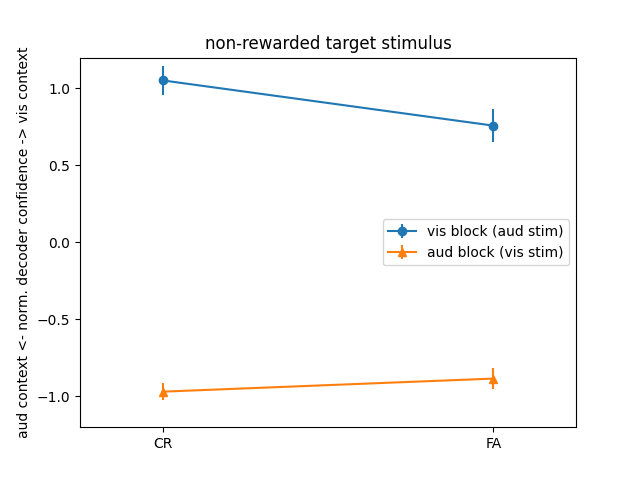

In [41]:
### plot avg decoder confidence for CR vs. FA for non-rewarded target

aa='all'
p='block_ids'
block_type=['vis1','sound1']

vis_block_cr_conf=np.zeros(len(sessions))
vis_block_cr_conf[:]=np.nan
vis_block_fa_conf=np.zeros(len(sessions))
vis_block_fa_conf[:]=np.nan
aud_block_cr_conf=np.zeros(len(sessions))
aud_block_cr_conf[:]=np.nan
aud_block_fa_conf=np.zeros(len(sessions))
aud_block_fa_conf[:]=np.nan

#for each session
for sel_session in range(0,len(svc_results)): #sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue

    for block in block_type:
        if block=='vis1':
            other_target='aud'
            other_stim = 'sound1'
        elif block=='sound1':
            other_target='vis'
            other_stim='vis1'
        
        
        if 'trialOptoVoltage' in sessions[sel_session].trials.columns:
            temp_trials = sessions[sel_session].trials.query('trialOptoVoltage.isnull()')
        else:
            temp_trials = sessions[sel_session].trials
        
        cr_trials = ((temp_trials['trialstimRewarded'] == block)&
                     (temp_trials['vis_autoreward_trials'] == False)&
                     (temp_trials['aud_autoreward_trials'] == False)&
                     (temp_trials['trialStimID'] == other_stim)&
                     (temp_trials['trial_response'] == False))
                                      
        
        fa_trials = ((temp_trials['trialstimRewarded'] == block)&
                     (temp_trials['vis_autoreward_trials'] == False)&
                     (temp_trials['aud_autoreward_trials'] == False)&
                     (temp_trials['trialStimID'] == other_stim)&
                     (temp_trials['trial_response'] == True))
        
#         cr_trials = temp_trials.query('trialstimRewarded == @block and \
#                                       vis_autoreward_trials == False and \
#                                       aud_autoreward_trials == False and \
#                                       trialStimID == @other_stim and \
#                                       trial_response == False')
        
#         fa_trials = temp_trials.query('trialstimRewarded == @block and \
#                                       vis_autoreward_trials == False and \
#                                       aud_autoreward_trials == False and \
#                                       trialStimID == @other_stim and \
#                                       trial_response == True')
        
        
#         cr_trials = ((~trial_info[sel_session]['autoreward'])&
#                      (trial_info[sel_session]['trialstimRewarded']==block)&
#                      (~trial_info[sel_session][other_target+'_target_response']))
        
#         fa_trials = ((~trial_info[sel_session]['autoreward'])&
#                      (trial_info[sel_session]['trialstimRewarded']==block)&
#                      (trial_info[sel_session][other_target+'_target_response']))
        
#         print('n cr trials = '+str(np.sum(cr_trials)))
#         print('n fa trials = '+str(np.sum(fa_trials)))
        
        
        #get decoder confidence
        decoder_cr_pred=((dec_func[sel_session][aa][p][cr_trials])
                          /np.nanstd(dec_func[sel_session][aa][p][cr_trials]))
        
        decoder_fa_pred=((dec_func[sel_session][aa][p][fa_trials])
                          /np.nanstd(dec_func[sel_session][aa][p][fa_trials]))
        
    
        
        if block=='vis1':
            vis_block_cr_conf[sel_session]=np.nanmean(decoder_cr_pred)
            vis_block_fa_conf[sel_session]=np.nanmean(decoder_fa_pred)
        elif block=='sound1':
            aud_block_cr_conf[sel_session]=np.nanmean(decoder_cr_pred)
            aud_block_fa_conf[sel_session]=np.nanmean(decoder_fa_pred)



fig,ax=plt.subplots()

ax.errorbar([0,1],[np.nanmean(vis_block_cr_conf),np.nanmean(vis_block_fa_conf)],
           [np.nanstd(vis_block_cr_conf)/np.sqrt(np.sum(~np.isnan(vis_block_cr_conf))),
            np.nanstd(vis_block_fa_conf)/np.sqrt(np.sum(~np.isnan(vis_block_fa_conf)))],marker='o')

ax.errorbar([0,1],[np.nanmean(aud_block_cr_conf),np.nanmean(aud_block_fa_conf)],
           [np.nanstd(aud_block_cr_conf)/np.sqrt(np.sum(~np.isnan(aud_block_cr_conf))),
            np.nanstd(aud_block_fa_conf)/np.sqrt(np.sum(~np.isnan(aud_block_fa_conf)))],marker='^')

ax.set_ylim([-1.2,1.2])

ax.set_xticks([0,1])
ax.set_xticklabels(['CR','FA'])
ax.set_xlim(-0.25,1.25)
ax.set_ylabel('aud context <- norm. decoder confidence -> vis context')

ax.set_title('non-rewarded target stimulus')
ax.legend(['vis block (aud stim)','aud block (vis stim)'])



<IPython.core.display.Javascript object>


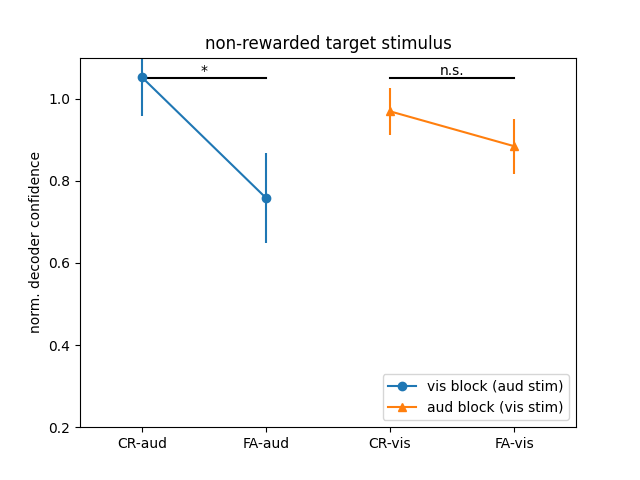

In [42]:
h,vis_p=st.wilcoxon(vis_block_cr_conf[~np.isnan(vis_block_cr_conf)],
            vis_block_fa_conf[~np.isnan(vis_block_fa_conf)])
h,aud_p=st.wilcoxon(aud_block_cr_conf[~np.isnan(aud_block_cr_conf)],
            aud_block_fa_conf[~np.isnan(aud_block_fa_conf)])

fig,ax=plt.subplots()

l1=ax.errorbar(np.asarray([0,1]),[np.nanmean(vis_block_cr_conf),np.nanmean(vis_block_fa_conf)],
           [np.nanstd(vis_block_cr_conf)/np.sqrt(np.sum(~np.isnan(vis_block_cr_conf))),
            np.nanstd(vis_block_fa_conf)/np.sqrt(np.sum(~np.isnan(vis_block_fa_conf)))],marker='o')

ax.plot([0,1],[1.05,1.05],'k')

if vis_p<0.001:
    ax.text(0.5,1.05,'***',ha='center',va='bottom')
elif vis_p<0.01:
    ax.text(0.5,1.05,'**',ha='center',va='bottom')
elif vis_p<0.05:
    ax.text(0.5,1.05,'*',ha='center',va='bottom')
elif vis_p>=0.05:
    ax.text(0.5,1.05,'n.s.',ha='center',va='bottom')

l2=ax.errorbar(np.asarray([2,3]),[-np.nanmean(aud_block_cr_conf),-np.nanmean(aud_block_fa_conf)],
           [np.nanstd(aud_block_cr_conf)/np.sqrt(np.sum(~np.isnan(aud_block_cr_conf))),
            np.nanstd(aud_block_fa_conf)/np.sqrt(np.sum(~np.isnan(aud_block_fa_conf)))],marker='^')

ax.plot([2,3],[1.05,1.05],'k')

if aud_p<0.001:
    ax.text(2.5,1.05,'***',ha='center',va='bottom')
elif aud_p<0.01:
    ax.text(2.5,1.05,'**',ha='center',va='bottom')
elif aud_p<0.05:
    ax.text(2.5,1.05,'*',ha='center',va='bottom')
elif aud_p>=0.05:
    ax.text(2.5,1.05,'n.s.',ha='center',va='bottom')

ax.set_ylim([0.2,1.1])

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['CR-aud','FA-aud','CR-vis','FA-vis'])
ax.set_xlim(-0.5,3.5)
ax.set_ylabel('norm. decoder confidence')

ax.set_title('non-rewarded target stimulus')
ax.legend([l1[0],l2[0]],['vis block (aud stim)','aud block (vis stim)'],loc='lower right')

In [ ]:
st.wilcoxon(vis_block_cr_conf[~np.isnan(vis_block_cr_conf)],
            vis_block_fa_conf[~np.isnan(vis_block_fa_conf)])
# st.wilcoxon(aud_block_cr_conf,aud_block_fa_conf,nan_policy='omit')

In [ ]:
st.wilcoxon(aud_block_cr_conf[~np.isnan(aud_block_cr_conf)],
            aud_block_fa_conf[~np.isnan(aud_block_fa_conf)])

<IPython.core.display.Javascript object>


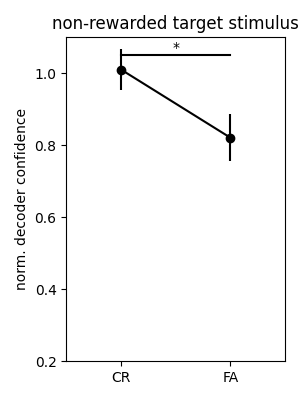

In [43]:
all_block_cr_conf=np.hstack([vis_block_cr_conf[~np.isnan(vis_block_cr_conf)],
                           -aud_block_cr_conf[~np.isnan(aud_block_cr_conf)]])

all_block_fa_conf=np.hstack([vis_block_fa_conf[~np.isnan(vis_block_fa_conf)],
                           -aud_block_fa_conf[~np.isnan(aud_block_fa_conf)]])

h,all_p=st.wilcoxon(all_block_cr_conf,all_block_fa_conf)

fig,ax=plt.subplots(figsize=(3,4))

l1=ax.errorbar(np.asarray([0,1]),[np.nanmean(all_block_cr_conf),np.nanmean(all_block_fa_conf)],
           [np.nanstd(all_block_cr_conf)/np.sqrt(np.sum(~np.isnan(all_block_cr_conf))),
            np.nanstd(all_block_fa_conf)/np.sqrt(np.sum(~np.isnan(all_block_fa_conf)))],marker='o',color='k')

ax.plot([0,1],[1.05,1.05],'k')

if all_p<0.001:
    ax.text(0.5,1.05,'***',ha='center',va='bottom')
elif all_p<0.01:
    ax.text(0.5,1.05,'**',ha='center',va='bottom')
elif all_p<0.05:
    ax.text(0.5,1.05,'*',ha='center',va='bottom')
elif all_p>=0.05:
    ax.text(0.5,1.05,'n.s.',ha='center',va='bottom')

# l2=ax.errorbar(np.asarray([2,3]),[-np.nanmean(aud_block_cr_conf),-np.nanmean(aud_block_fa_conf)],
#            [np.nanstd(aud_block_cr_conf)/np.sqrt(np.sum(~np.isnan(aud_block_cr_conf))),
#             np.nanstd(aud_block_fa_conf)/np.sqrt(np.sum(~np.isnan(aud_block_fa_conf)))],marker='^')

# ax.plot([2,3],[1.05,1.05],'k')

# if aud_p<0.001:
#     ax.text(2.5,1.05,'***',ha='center',va='bottom')
# elif aud_p<0.01:
#     ax.text(2.5,1.05,'**',ha='center',va='bottom')
# elif aud_p<0.05:
#     ax.text(2.5,1.05,'*',ha='center',va='bottom')
# elif aud_p>=0.05:
#     ax.text(2.5,1.05,'n.s.',ha='center',va='bottom')

ax.set_ylim([0.2,1.1])

ax.set_xticks([0,1])
ax.set_xticklabels(['CR','FA'])
ax.set_xlim(-0.5,1.5)
ax.set_ylabel('norm. decoder confidence')

ax.set_title('non-rewarded target stimulus')
# ax.legend([l1[0],l2[0]],['vis block (aud stim)','aud block (vis stim)'],loc='lower right')
fig.tight_layout()

In [ ]:
all_p

In [ ]:
np.sum(~np.isnan(vis_block_cr_conf))

In [ ]:
aud_block_fa_conf

In [ ]:
#comp within aud targets
st.wilcoxon(aud_resp_prob[0],aud_resp_prob[2],nan_policy='omit')

In [ ]:
#comp within vis targets
st.wilcoxon(vis_resp_prob[0],vis_resp_prob[2],nan_policy='omit')

In [ ]:
#comp 1st timepoint
st.ranksums(aud_resp_prob[0],vis_resp_prob[0],nan_policy='omit')

In [ ]:
#comp 2nd timepoint
st.ranksums(aud_resp_prob[1],vis_resp_prob[1],nan_policy='omit')

In [ ]:
#comp 3rd timepoint
st.ranksums(aud_resp_prob[2],vis_resp_prob[2],nan_policy='omit')

In [ ]:
#shuffle!
# find probability of response depending on decoder accuracy

aa='CP'
p='block_ids'

# xbins=np.arange(-1,1.1,0.66)
xbins = np.asarray([-1.1,-1/3,1/3,1.1])
xbin_midpoints=(xbins[:-1]+xbins[1:])/2

vis_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
vis_resp_prob[:]=np.nan
aud_resp_prob=np.zeros((len(xbin_midpoints),len(sessions)))
aud_resp_prob[:]=np.nan

# sel_session=0

for sel_session in sessions:
    
    if aa not in predict_perf[sel_session].keys():
        continue
    
    # vis_resp_prob=np.zeros(len(xbin_midpoints))
    # aud_resp_prob=np.zeros(len(xbin_midpoints))

    decoder_pred=np.mean(predict_perf[sel_session][aa][p],axis=1)
    block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label']
#     stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label']
    stim_label=trial_info[sel_session]['trialStimID']

#     #make sound blocks a negative prediction
#     for xx in range(0,len(decoder_pred)):
#         if 'sound' in block_label[xx]:
#             decoder_pred[xx]=-decoder_pred[xx]
    decoder_pred = (decoder_pred*2)-1
    
    decoder_pred = np.random.choice(decoder_pred,len(decoder_pred),replace=False)

    vis_target_response=trial_info[sel_session]['vis_target_response']
    aud_target_response=trial_info[sel_session]['aud_target_response']
    
    vis_target=np.where(trial_info[sel_session]['vis_target'])[0]
    aud_target=np.where(trial_info[sel_session]['aud_target'])[0]

    for bb in range(0,len(xbins[:-1])):

#         vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
#         vis_resp_prob[bb,sel_session]=np.nanmean(
#             vis_target_response[np.random.choice(vis_target,np.sum(vis_trial_idx),replace=False)])
#         if np.isnan(vis_resp_prob[bb,sel_session]):
#             vis_resp_prob[bb,sel_session]=0

#         aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
#         aud_resp_prob[bb,sel_session]=np.nanmean(
#             aud_target_response[np.random.choice(aud_target,np.sum(aud_trial_idx),replace=False)])
#         if np.isnan(aud_resp_prob[bb,sel_session]):
#             aud_resp_prob[bb,sel_session]=0

        vis_trial_idx=(stim_label=='vis1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        vis_resp_prob[bb,sel_session]=np.nanmean(vis_target_response[vis_trial_idx])
        if np.isnan(vis_resp_prob[bb,sel_session]):
            vis_resp_prob[bb,sel_session]=0

        aud_trial_idx=(stim_label=='sound1')&(decoder_pred>=xbins[bb])&(decoder_pred<xbins[bb+1])
        aud_resp_prob[bb,sel_session]=np.nanmean(aud_target_response[aud_trial_idx])
        if np.isnan(aud_resp_prob[bb,sel_session]):
            aud_resp_prob[bb,sel_session]=0

        
fig,ax1=plt.subplots()
#vis performance plot
color = 'blue'
ax1.set_xlabel('auditory <- decoder context prediction -> visual')
ax1.set_ylabel('prob. aud target lick', color=color)
ax1.plot(xbin_midpoints,aud_resp_prob,color=color,linewidth=0.75,alpha=0.5)
ax1.plot(xbin_midpoints,np.nanmean(aud_resp_prob,axis=1),color=color,linewidth=2,marker='o')
ax1.tick_params(axis ='y', labelcolor = color)
ax1.set_ylim([0.2,1.1])
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'green'
ax2.set_ylabel('prob. vis target lick', color=color)
ax2.plot(xbin_midpoints,vis_resp_prob,color=color,linewidth=0.75,alpha=0.5)
ax1.plot(xbin_midpoints,np.nanmean(vis_resp_prob,axis=1),color=color,linewidth=2,marker='o')
ax2.tick_params(axis ='y', labelcolor = color)
ax2.set_ylim([0.2,1.1])

# ax.plot(xbin_midpoints,aud_resp_prob,'b',linewidth=1)

ax1.set_title('area '+aa+' - shuffled')

In [ ]:
predict_perf[sel_session][aa][p].shape

In [ ]:
trial_info[sel_session]['vis_target_response'].shape

In [ ]:
# true_label
# decoder_pred

In [ ]:
decoder_acc_session_mean

## decoding across areas

In [ ]:
# loop through areas

area_block_decoding={}

for aa in unique_areas:
    
    # compile avg prestim decoding per area x session
    area_block_decoding[aa]=decoder_acc_session_mean[aa]['block_ids']['vis1'][0]

    
area_block_decoding=pd.DataFrame(area_block_decoding)
area_block_decoding

In [ ]:
area_block_decoding.columns[(area_block_decoding.isna().sum()<=(len(svc_results)-5))]

In [ ]:
min_n_recs=5

area_means=area_block_decoding.mean()[(area_block_decoding.isna().sum()<=(len(svc_results)-min_n_recs))].sort_values(ascending=False)
area_stds=area_block_decoding.sem()[(area_block_decoding.isna().sum()<=(len(svc_results)-min_n_recs))].loc[area_means.index]



fig,ax=plt.subplots(figsize=(6,2.5))
ax=area_means.plot.bar()

ax.errorbar(area_means.index,area_means.values,area_stds.values,linestyle='')

ax.set_ylim([0.5,0.8])
ax.set_ylabel('context decoding accuracy')

fig.tight_layout()

## plot decoder performance by block number

In [ ]:

for aa in unique_areas:

    #aa='MOs'
    p='block_ids'

    xbins = np.asarray([1,2,3,4,5,6])

    decoder_by_block_visfirst=np.zeros((len(xbins),len(sessions)))
    decoder_by_block_visfirst[:]=np.nan

    decoder_by_block_visfirst_shuffle=np.zeros((len(xbins),len(sessions)))
    decoder_by_block_visfirst_shuffle[:]=np.nan

    decoder_by_block_audfirst=np.zeros((len(xbins),len(sessions)))
    decoder_by_block_audfirst[:]=np.nan

    decoder_by_block_audfirst_shuffle=np.zeros((len(xbins),len(sessions)))
    decoder_by_block_audfirst_shuffle[:]=np.nan


    for sel_session in range(0,len(svc_results)): #sessions:

        if aa not in predict_perf[sel_session].keys():
            continue

        incl_trials = ~trial_info[sel_session]['autoreward']

#         decoder_pred=np.mean(predict_perf[sel_session][aa][p][incl_trials,:],axis=1)
        decoder_pred=dec_func[sel_session][aa][p][incl_trials]/np.std(dec_func[sel_session][aa][p][incl_trials])
        decoder_pred_shuffle = np.random.choice(decoder_pred,len(decoder_pred),replace=False)

        block_label=svc_results[sel_session]['block_ids'][aa][0][0]['true_label'][incl_trials]
        stim_label=svc_results[sel_session]['stim_ids'][aa][0][0]['true_label'][incl_trials]

        block_num=trial_info[sel_session]['block_number'][incl_trials]
        block_num_shuffle=np.random.choice(block_num,len(block_num),replace=False)


        for ib,bb in enumerate(xbins):

            if block_label[0]=='vis1':
                trial_idx=block_num==bb
                decoder_by_block_visfirst[ib,sel_session]=np.mean(decoder_pred[trial_idx])
        #         if np.isnan(decoder_by_block[ib,sel_session]):
        #             decoder_by_block[ib,sel_session]=0

                trial_idx=block_num_shuffle==bb
                decoder_by_block_visfirst_shuffle[ib,sel_session]=np.mean(decoder_pred[trial_idx])
        #         if np.isnan(decoder_by_block_shuffle[ib,sel_session]):
        #             decoder_by_block_shuffle[ib,sel_session]=0

            elif block_label[0]=='sound1':
                trial_idx=block_num==bb
#                 decoder_by_block_audfirst[ib,sel_session]=np.mean(decoder_pred[trial_idx])
#         #         if np.isnan(decoder_by_block[ib,sel_session]):
#         #             decoder_by_block[ib,sel_session]=0

#                 trial_idx=block_num_shuffle==bb
#                 decoder_by_block_audfirst_shuffle[ib,sel_session]=np.mean(decoder_pred[trial_idx])
#         #         if np.isnan(decoder_by_block_shuffle[ib,sel_session]):
#         #             decoder_by_block_shuffle[ib,sel_session]=0

                decoder_by_block_visfirst[ib,sel_session]=-np.mean(decoder_pred[trial_idx])
        #         if np.isnan(decoder_by_block[ib,sel_session]):
        #             decoder_by_block[ib,sel_session]=0

                trial_idx=block_num_shuffle==bb
                decoder_by_block_visfirst_shuffle[ib,sel_session]=-np.mean(decoder_pred[trial_idx])
        #         if np.isnan(decoder_by_block_shuffle[ib,sel_session]):
        #             decoder_by_block_shuffle[ib,sel_session]=0



    fig,ax=plt.subplots()

    #vis performance plot

    ax.set_xlabel('block number')
#     ax.set_ylabel('prob. visual context')
    ax.set_ylabel('decoder confidence')

#     #true decoder accuracy
#     y1=np.nanmean(decoder_by_block_audfirst,axis=1)
#     err1=np.nanstd(decoder_by_block_audfirst,axis=1)/np.sqrt(np.sum(~np.isnan(decoder_by_block_audfirst[0,:])))
#     l1aud=ax.plot(xbins, y1,'b',linestyle='-',marker='o')
#     plt.fill_between(xbins, y1-err1, y1+err1,
#         alpha=0.2, edgecolor=None, facecolor='b')

    y1=np.nanmean(decoder_by_block_visfirst,axis=1)
    err1=np.nanstd(decoder_by_block_visfirst,axis=1)/np.sqrt(np.sum(~np.isnan(decoder_by_block_visfirst[0,:])))
    l1vis=ax.plot(xbins, y1,'g',linestyle='-',marker='o')
    plt.fill_between(xbins, y1-err1, y1+err1,
        alpha=0.2, edgecolor=None, facecolor='g')


#     #shuffle
#     y0=np.nanmean(decoder_by_block_audfirst_shuffle,axis=1)
#     err0=np.nanstd(decoder_by_block_audfirst_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(decoder_by_block_audfirst_shuffle[0,:])))
#     l0=ax.plot(xbins, y0,'b',linestyle='--',alpha=0.5)
#     plt.fill_between(xbins, y0-err0, y0+err0,
#         alpha=0.1, edgecolor=None, facecolor='b')

    y0=np.nanmean(decoder_by_block_visfirst_shuffle,axis=1)
    err0=np.nanstd(decoder_by_block_visfirst_shuffle,axis=1)/np.sqrt(np.sum(~np.isnan(decoder_by_block_visfirst_shuffle[0,:])))
    l0=ax.plot(xbins, y0,'g',linestyle='--',alpha=0.5)
    plt.fill_between(xbins, y0-err0, y0+err0,
        alpha=0.1, edgecolor=None, facecolor='g')

#     ax.legend(['aud block first','vis block first'])
    ax.set_ylim([-1,1])
    ax.set_title('area '+aa)
    
    fig.tight_layout()
    
#     figpath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2023-04-17-DR-decoding-by_block_accuracy"
#     figname=aa+'_by_block_context_decoding.png'
#     figname=figname.replace('/','-')
#     plt.savefig(os.path.join(figpath,figname), dpi=600, facecolor='w', edgecolor='w',
#                 orientation='portrait', format='png',
#                 transparent=True, bbox_inches='tight', pad_inches=0.1,
#                 metadata=None)

In [ ]:
#next: try plotting prob(vis target lick) and prob(aud target lick)



## performance vs. trials since last bit of information

In [23]:
#use decoder confidence?

sel_session=0

#svc_results[sel_session][predict_var][area][timepoint][repeat]

norm_dec_func=svc_results[sel_session]['block_ids']['MOs'][18][0]['decision_function']/np.nanstd(
    svc_results[sel_session]['block_ids']['MOs'][18][0]['decision_function'])

rewarded_trials=trial_info[sel_session]['trial_rewarded']
response_trials=trial_info[sel_session]['trial_response']

vis_target_response=trial_info[sel_session]['vis_target_response']
aud_target_response=trial_info[sel_session]['aud_target_response']

KeyError: 'MOs'

In [ ]:
svc_results[sel_session]['block_ids']['MOs'].keys()

In [ ]:
fig,ax=plt.subplots()
ax.axhline(0)
ax.plot(norm_dec_func,'k')

# ax.vlines(np.where(response_trials)[0],ymin=-4,ymax=4,color='red')
# ax.vlines(np.where(rewarded_trials)[0],ymin=-4,ymax=4,color='blue')

ax.vlines(np.where(vis_target_response)[0],ymin=-4,ymax=4,color='red')
ax.vlines(np.where(aud_target_response)[0],ymin=-4,ymax=4,color='blue')

In [ ]:
#first try for a single session?

#invert decoder confidence for auditory blocks

#find all trials where the last reward was on the last trial

#iterate through, 2, 3, 4, 5 trials ago etc.

#also do this for last unrewarded response

In [ ]:
# trials since transition?

In [ ]:
# does information affect decoder confidence more if it is already far from zero?

## before and after bit of information

In [ ]:
#use decoder confidence?

## feature importance

<IPython.core.display.Javascript object>


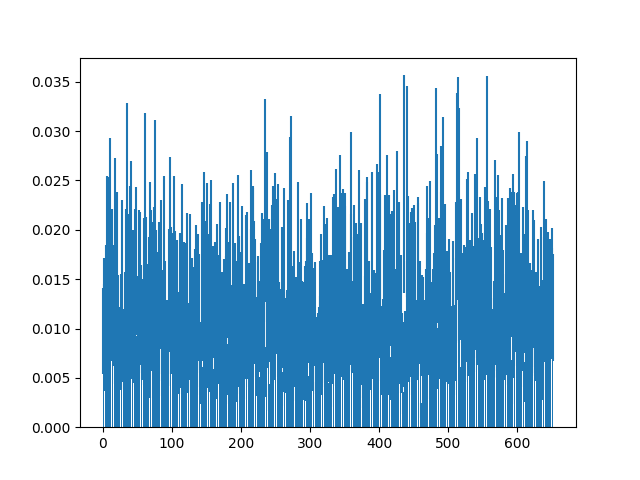

<ErrorbarContainer object of 3 artists>

In [25]:
n_reps=len(np.vstack(svc_results[0]['block_ids']['all'][20][0]['coefs']))
coef_mean=np.std(np.vstack(svc_results[0]['block_ids']['all'][20][0]['coefs']),axis=0)
coef_std=np.std(np.vstack(svc_results[0]['block_ids']['all'][20][0]['coefs']),axis=0)/np.sqrt(n_reps)

uids=svc_results[0]['block_ids']['all'][20][0]['unit_sel_idx']

xvals=np.arange(0,len(coef_mean))

fig,ax=plt.subplots()
ax.bar(xvals,coef_mean)
ax.errorbar(xvals,coef_mean,coef_std,linestyle='')

In [ ]:
MOs_units=sessions[0].good_units.query('area.str.contains("MOs")')
MOs_units.columns

In [ ]:
all_metrics=MOs_units.columns.values


for mm in all_metrics:
    
    if 'area' in mm:
        continue
    
    nan_ind=MOs_units[mm].isnull()
    
    r,p=st.pearsonr(MOs_units[mm][~nan_ind],coef_mean[~nan_ind])
    
    if np.isnan(r):
        continue
    
    
    fig,ax=plt.subplots()
    ax.plot(MOs_units[mm],coef_mean,'k.')
    ax.set_xlabel(mm)
    ax.set_ylabel('coef')
    
    ax.set_title('r='+str(np.round(r,decimals=2))+'; p='+str(np.round(p,decimals=4)))
    

In [ ]:
'area' in mm

In [ ]:
#change across timepoints??

In [ ]:
#any patterns in which units are more important?